# TP3 - Views, Updates and Design

The objectives for this TP are:

1. Create and use SQL Views
2. Update database content
3. Design the database schema for a Social Network

___

For the first 2 parts we will use the **`wine.db`** database and the Tables created in TP2.

A reminder of the wine database schema:

<center>**Master1**</center>

|*Attribute*|         *Description*          |
| -------   |--------------------------------|
| NV        | Wine number                    |
| CRU       | Vineyard or group of vineyards |
| DEGRE     | Alcohol content                |
| MILL      | Vintage year                   |
| QTE       | Number of bottles harvested    |
| NP        | Producer number                |
| NOM       | Producer's last name           |
| PRENOM    | Producer's first name          |
| REGION    | Production region              |

<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |


In [1]:
import sqlite3

In [2]:
def printSchema(connection):
    ### Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [3]:
conn = sqlite3.connect('wine.db')
c = conn.cursor()
print("Database schema:")
printSchema(conn)

Database schema:
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
RBA:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
RBB:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
client:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
location:
  0: LIEU(TEXT)
  1: REGION(TEXT)
producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
sales:
  0: NP(NUM)
  1: NV(NUM)
  2: QTE(NUM)
sales2:
  0: NV(NUM)
  1: NB(NUM)
  2: DATES(NUM)
  3: LIEU(TEXT)
  4: QTE(NUM)
wine:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
wine2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)


Again, we will use **`%%sql`** magic for our queries

In [4]:
%load_ext sql
%sql sqlite:///wine.db

'Connected: @wine.db'

Recreate the Normalized Tables from **Master1** and **Master2** as you did in the TP2

I first create the tables from Master1: wine, sales and producer

In [5]:
%%sql DROP TABLE IF EXISTS wine;

CREATE TABLE wine AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER1
WHERE NV IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [6]:
%%sql DROP TABLE IF EXISTS sales;

CREATE TABLE sales AS
SELECT NP, NV, QTE
FROM MASTER1
WHERE NV IS NOT NULL AND NP IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [7]:
%%sql DROP TABLE IF EXISTS producer;

CREATE TABLE producer AS
SELECT DISTINCT NP, NOM, PRENOM, REGION
FROM MASTER1
WHERE NP IS NOT NULL;

 * sqlite:///wine.db
Done.
Done.


[]

Then create the tables from Master2: wine2, sales2, client and location

In [8]:
%%sql DROP TABLE IF EXISTS wine2;

CREATE TABLE wine2 AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER2
WHERE NV IS NOT NULL
ORDER BY NV;

 * sqlite:///wine.db
Done.
Done.


[]

In [9]:
%%sql DROP TABLE IF EXISTS client;

CREATE TABLE client AS
SELECT DISTINCT NB, NOM, PRENOM, TYPE
FROM MASTER2
WHERE NB IS NOT NULL
ORDER BY NB;

 * sqlite:///wine.db
Done.
Done.


[]

In [10]:
%%sql DROP TABLE IF EXISTS location;

CREATE TABLE location AS
SELECT DISTINCT LIEU, REGION
FROM MASTER2
WHERE LIEU IS NOT NULL
ORDER BY LIEU;

 * sqlite:///wine.db
Done.
Done.


[]

In [11]:
%%sql DROP TABLE IF EXISTS sales2;

CREATE TABLE sales2 AS
SELECT distinct NV, NB, DATES, LIEU, QTE
FROM MASTER2
WHERE NV IS NOT NULL AND NB IS NOT NULL
ORDER BY NV;

 * sqlite:///wine.db
Done.
Done.


[]

___
# PART I: CREATE AND USE VIEWS

A view is a virtual table based on the result-set of an SQL statement. Views are stored in the database with an associated name.

Views are created following the syntax:

```mysql
CREATE VIEW view_name AS
SELECT column1, column2.....
FROM table_name
WHERE [condition];
```

An useful command:

```mysql
DROP VIEW IF EXISTS view_name;
```


__Warning:__ Use `DROP` with caution (only drop something if you are sure)

__Note:__ You will find some cells marked as "Test" that will help you check your work. Do NOT modify them. 

#### Exercise 1.1

Create a view "**bons_buveurs**" with the clients (buveurs) of type 'gros' or 'moyen'.

Note: the question is ambiguous on which attributes should be or not included in the view "bons_buveurs". I consider that besides NB, the attributes NOM and PRENOM are also useful. As for the TYPE attribute, the choice is not obvious. It is the attribute on which selection is operated, so it may be dropped (as we are sure that any client in the view is "moyen" or "gros"). However, as there are still two different types of clients in the view , TYPE also carries useful information. I will therefore consider that it is relevant to preserve TYPE, and include it in the view.

First create a table that will contain the information for bon_buveurs.

In [12]:
%%sql

DROP VIEW IF EXISTS BONS_BUVEURS;

CREATE VIEW BONS_BUVEURS AS
SELECT CLIENT.NB, CLIENT.NOM, CLIENT.PRENOM, CLIENT.TYPE
FROM CLIENT
WHERE CLIENT.TYPE = "moyen" OR CLIENT.TYPE = "gros";

 * sqlite:///wine.db
Done.
Done.


[]

In [13]:
# Test
%sql SELECT * FROM bons_buveurs ORDER BY nb;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
2,Artaud,Antonin,moyen
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
10,Andersen,Yann,gros
12,Bataille,Georges,moyen
13,Barthes,Roland,moyen
14,Bory,Jean Louis,gros


#### Exercise 1.2

Create the view "**buveurs_asec**" with clients (buveurs) who have not bought any wine.

In [14]:
%%sql

DROP VIEW IF EXISTS BUVEURS_ASEC;

CREATE VIEW BUVEURS_ASEC AS
SELECT CLIENT.NB, CLIENT.NOM, CLIENT.PRENOM, CLIENT.TYPE
FROM CLIENT
LEFT OUTER JOIN SALES2
ON CLIENT.NB = SALES2.NB
WHERE QTE IS NULL;

 * sqlite:///wine.db
Done.
Done.


[]

In [15]:
# Test
%sql SELECT * FROM buveurs_asec ORDER BY nb;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
11,Breton,Andre,petit
13,Barthes,Roland,moyen
16,Balzac,Honore de,moyen
18,Celine,Louis Ferdinand,gros
20,Chateaubriand,Francois-Rene de,moyen
21,Corbiere,Tristan,petit
23,Corneille,Pierre,petit
25,Char,Rene,petit
27,Dumas,Alexandre,gros
29,Fournier,Alain,petit


#### Exercise 1.3

Create the view "**buveurs_achats**" complementary to the previous one.

In [16]:
%%sql

DROP VIEW IF EXISTS BUVEURS_ACHATS;

CREATE VIEW BUVEURS_ACHATS AS
SELECT CLIENT.NB, CLIENT.NOM, CLIENT.PRENOM, CLIENT.TYPE
FROM CLIENT
EXCEPT
SELECT BUVEURS_ASEC.NB, BUVEURS_ASEC.NOM, BUVEURS_ASEC.PRENOM, BUVEURS_ASEC.TYPE
FROM BUVEURS_ASEC;

 * sqlite:///wine.db
Done.
Done.


[]

In [17]:
# Test
%sql SELECT * FROM buveurs_achats;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
1,Aristote,None,petit
2,Artaud,Antonin,moyen
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
5,Audiberti,Jacques,petit
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
9,Ajar,Emile,petit
10,Andersen,Yann,gros


#### Exercise 1.4

Create the view "**q83pl**" (LIEU, CRU, QTE_BUE) that provides by LIEU and CRU the total quantities bought in 1983 by all the clients (buveurs).

In [18]:
%%sql

DROP VIEW IF EXISTS Q83PL;

CREATE VIEW Q83PL AS
SELECT SALES2.LIEU, WINE2.CRU, SUM(SALES2.QTE) AS QTE_BUE
FROM WINE2, SALES2
WHERE WINE2.NV = SALES2.NV
AND DATES LIKE '1983%'
GROUP BY LIEU, CRU;

 * sqlite:///wine.db
Done.
Done.


[]

In [19]:
# Test
%sql SELECT * FROM q83pl;

 * sqlite:///wine.db
Done.


LIEU,CRU,QTE_BUE
CAEN,Seyssel,3
LILLE,Pommard,5
LYON,Beaujolais Villages,10
LYON,Julienas,2
PARIS,Beaujolais Primeur,4
PARIS,Coteaux du Tricastin,1
PARIS,Pouilly Vinzelles,3
RENNES,Mercurey,1
ROCQUENCOURT,Beaujolais Villages,260
ROCQUENCOURT,Saint Amour,80


#### Exercise 1.5

Can we define the same view with ascending order over the attribute "QTE"? Provide an explanation for your answer.

Answer: No, ordering over "QTE" would not produce the same view. Using the original QTE attribute for ordering would deliver a sorting consistent with the original values of QTE. However, the QTE attribute has been summed over several tuples of LIEU and CRU, and so the new attribute QTE_BUE may have an ordering which is different from the original QTE ordering. To obtain a correct sorting in the view Q83PL, order over QTE_BUE rather than QTE.

Anyway, one should not include an "order by" statement in a view unless necessary. Rather, one should use the "order by" statement in a request based on this view.

___
# PART II: UPDATE DATABASE CONTENT

The syntax for the `UPDATE` operation is:

```sql
UPDATE table_name
SET column1 = value1, column2 = value2...., columnN = valueN
WHERE [condition];
```

The syntax for the `INSERT` operation is:

```sql
INSERT INTO table_name [(column1, column2, column3,...columnN)]  
VALUES (value1, value2, value3,...valueN);
```

Database updates are commited automatically in Jupyter/Python. _Transactions_ are an option to control and reverse changes. Additionally we can just reload a backup of the database (NOT an option in deployed systems)

__Note:__ Different to other Database Management Systems, SQLite views are read-only and so you can not execute a `DELETE`, `INSERT` or `UPDATE` statement on a view.

#### Exercise 2.1

Create a table "**RBB**" with the same schema as "**bons_buveurs**" which contains the tuples selected from "**bons_buveurs**"

In [20]:
%%sql DROP TABLE IF EXISTS RBB;

CREATE TABLE RBB AS
SELECT * FROM BONS_BUVEURS;

 * sqlite:///wine.db
Done.
Done.


[]

In [21]:
# Test
%sql SELECT * FROM RBB;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
2,Artaud,Antonin,moyen
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
10,Andersen,Yann,gros
12,Bataille,Georges,moyen
13,Barthes,Roland,moyen
14,Bory,Jean Louis,gros


#### Exercise 2.2

Update the table you used to create "**bons_buveurs**": Change the "type" to 'gros' if the total of quantities bought is over 100.

In [22]:
%%sql
SELECT CLIENT.NB, CLIENT.NOM, CLIENT.PRENOM, CLIENT.TYPE, SUM(SALES2.QTE) AS TOTAL
FROM SALES2, CLIENT
WHERE CLIENT.NB = SALES2.NB
AND CLIENT.TYPE <> "gros"
GROUP BY SALES2.NB
HAVING TOTAL > 100;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE,TOTAL
2,Artaud,Antonin,moyen,583
5,Audiberti,Jacques,petit,113
9,Ajar,Emile,petit,140
44,Gide,Andre,petit,171


In [23]:
%%sql 
UPDATE CLIENT
SET TYPE = 'gros'
WHERE CLIENT.NB IN (SELECT SALES2.NB
                    FROM SALES2
                    GROUP BY SALES2.NB
                    HAVING SUM(SALES2.QTE)>100
                   )
AND CLIENT.TYPE <> "gros";

 * sqlite:///wine.db
4 rows affected.


[]

#### Exercise 2.3

Compare the content of _table_ "**RBB**" and the _view_ "**bons_buveurs**" after the update. What differences do you see? Explain

In [24]:
%%sql
SELECT * FROM BONS_BUVEURS
LIMIT 10;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
2,Artaud,Antonin,gros
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
5,Audiberti,Jacques,gros
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
9,Ajar,Emile,gros
10,Andersen,Yann,gros
12,Bataille,Georges,moyen


In [25]:
%%sql
SELECT * FROM RBB
LIMIT 10;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
2,Artaud,Antonin,moyen
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
10,Andersen,Yann,gros
12,Bataille,Georges,moyen
13,Barthes,Roland,moyen
14,Bory,Jean Louis,gros


I can see a difference between the bons_buveurs view and the RBB table. bons_buveurs has been updated once the CLIENT relation was modified to set the TYPE of CLIENT to 'gros' whenever the total quantities bought was over 100. RBB on the other hand has been left unchanged. For instance, prior to the change in the CLIENT table, Jacques Audiberti (NB = 5) was a buveur of TYPE small and was hence omitted both in the view bons_buveurs and the table RBB. After the change in client, Jacques Audiberti became considered as a client of type "gros" (his total purchase being 20 + 10 + 80 + 3 = 113 > 100). This change is reflected in the view bons_buveurs, which now includes Jacques Audiberti. On the other hand, the table RBB still omits Jacques Audiberti.

The reason for this lies in the fundamental difference between a view and a table. A view is merely a visualisation (or representation) of an SQL request involving some tables. If these underlying tables are modified, so is the outcome of the request, and thus the view is immediately updated to account for the changes in the tables. This is why an update in the table CLIENT is immediately reflected in the view bons_buveurs.
Tables, by contrast, are objects which have an existence on their own and are not affected by changes in other tables. Therefore, a change in the CLIENT table does not affect the table RBB, which explains for instance why Jacques Audiberti remains absent from RBB.

#### Exercise 2.4

Create a table "**RBA**" with the same schema as "**buveurs_asec**" which contains the tuples selected from "**buveurs_asec**"

In [26]:
%%sql DROP TABLE IF EXISTS RBA;

CREATE TABLE RBA AS
SELECT * FROM BUVEURS_ASEC;

 * sqlite:///wine.db
Done.
Done.


[]

In [27]:
# Test
%sql SELECT * FROM RBA

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
11,Breton,Andre,petit
13,Barthes,Roland,moyen
16,Balzac,Honore de,moyen
18,Celine,Louis Ferdinand,gros
20,Chateaubriand,Francois-Rene de,moyen
21,Corbiere,Tristan,petit
23,Corneille,Pierre,petit
25,Char,Rene,petit
27,Dumas,Alexandre,gros
29,Fournier,Alain,petit


#### Exercise 2.5

Insert a tuple (101, 'your last name', 'your first name', 'your type of purchases(petit, moyen, or gros)') to "**RBA**".

In [28]:
%%sql

INSERT INTO RBA (NB, NOM, PRENOM, TYPE)
VALUES
(101, "Legrand", "Romain", "gros");

 * sqlite:///wine.db
1 rows affected.


[]

In [29]:
# Test
%sql SELECT * FROM RBA

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
11,Breton,Andre,petit
13,Barthes,Roland,moyen
16,Balzac,Honore de,moyen
18,Celine,Louis Ferdinand,gros
20,Chateaubriand,Francois-Rene de,moyen
21,Corbiere,Tristan,petit
23,Corneille,Pierre,petit
25,Char,Rene,petit
27,Dumas,Alexandre,gros
29,Fournier,Alain,petit


#### Exercise 2.6

Compare the content of _table_ "**RBA**" and the _view_ "**buveurs_asec**". What differences do you see? Explain

In [30]:
%%sql

SELECT * FROM (
SELECT * FROM buveurs_asec ORDER BY NB DESC LIMIT 10)
ORDER BY NB ASC;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
86,Saint Exupery,Antoine de,gros
87,Segur,Comtesse de,gros
88,Shakespeare,William,petit
89,Stendhal,None,petit
90,Vian,Boris,petit
91,Verlaine,Paul,gros
93,Virgile,None,gros
95,Zorn,Fritz,moyen
98,Maturin,Robert,gros
99,Cesar,Jules,gros


In [31]:
%%sql

SELECT * FROM (
SELECT * FROM RBA ORDER BY NB DESC LIMIT 10)
ORDER BY NB ASC;

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,TYPE
87,Segur,Comtesse de,gros
88,Shakespeare,William,petit
89,Stendhal,None,petit
90,Vian,Boris,petit
91,Verlaine,Paul,gros
93,Virgile,None,gros
95,Zorn,Fritz,moyen
98,Maturin,Robert,gros
99,Cesar,Jules,gros
101,Legrand,Romain,gros


It is again easy to see the difference between the view buveurs_asec and the table RBA. While the table RBA is affected by the insertion of the final tuple, the view buveurs_asec has not been changed. This is - again - because the view buveurs_asec is only a visualisation of an sql request involving some tables, in this case the CLIENT and SALES2 tables. Because these tables have not been updated  with the insertion of tuple 101, they remain unchanged, and so is the view buveurs_asec. On the other hand RBA is a table, so inserting tuple 101 in it does create a modification, which is immediately refelcted in the display of the table.

___
# PART III: Design the database schema for posts in a Social Network

In this section your task is to design the database schema for a social network app of a new startup:

The new social network will contain users, where each user will have a name, a nickname, an email, date of birth, and an address (Street, City, State, Country, Postal Code). Users can be friends of other users, and can publish posts. Each post can contain a text, date and attachment. Posts can be either original posts or replies so the app needs to handle both scenarios. When users log in, the app needs to display the posts of their friends.

**Note:** You can create diagrams of your proposal and insert them as images into this notebook.

#### Exercise 3.1

Write and explain the design of the relations of your database

I first create an entity-relationship model for the social network. The model is diplayed in the picture hereafter:

file:///home/romain/Bureau/ER%20diagram.png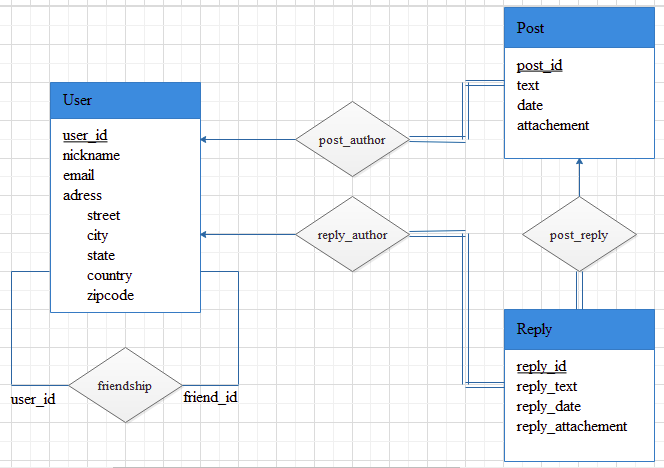

Explanation: There are basically three fundamental entities sets in this model.

1/ Users. Each user in the network is associated to a number of attributes, including a name, a nickname, an email, date of birth, and an address. The adress obviously constitutes a composite attribute, which is why the component attributes Street, City, State, Country and Zip Code are preceded by a tab. Also, each user is associated to a unique user_id. The unicity of each user_id is sufficient to make it a primary key of the entity set. Any user can be the friend of some other user. One possibility would have been to represent friends in a separate entity set called friends. But then the User and Friends entity sets would have been redundant, since any user is the friend of some other user. For this reason, it seems simpler and more efficient to use roles: I create for the User entity set a friendship relation with two roles, one being user_id, the other being friend_id. 

2/ Posts. Any user can publish posts. To keep things simple, I assume that each post in the network receives a unique post_id. Therefore, no two posts over the whole social network may share the same id and this way the attribute post_id is sufficient to uniquely identify any post. It thus represents a primary key for the entity set. Posts have three attributes: text, date and attachements. As (in theory) two different users may write the same post with similar text, date and attachement, the post_id attribute is required to ensure proper identification of the post. Posts are associated with users through the relationship post_author. It is a one to many relationship, with total participation on the post side: every post must be associated with an author, but no more than one author. Each user on the other hand may be the author of several different posts.

3/ Replies. This represents the most complicated entity set. The basic elements are nothing special since a reply is just a normal post: so it has the same attributes reply_text, reply_date and reply_attachement as Posts. For simplicity, I also assume that replies are like posts in the sense that each reply is associated to a unique id in my network (reply_id are independent from post_id). Therefore, those id are sufficient to uniquely identify each reply and constitute a primary key for the entity set. Things become more complicated when it comes to consider how to treat the relation between replies and the other entity sets, in particular Posts.
Clearly, replies are posts themselves. So one may attempt to create a relationship replies_to with two roles ("original post" or "reply"), similarly to users. This would not word however: if any member of Users can be both a user and a friend, no reply can play the role of an original post. So roles are not suitable here. A second possibility would be to treat replies like regular posts and include them in the Posts entity sets. Each post would then be associated with a "type" attribute ("original post" or "reply"), and reply type posts would have a non-null attribute "reply_to" providing the post_id of the post to which it responds. This is possible but heavy. Yet another possibility would be to notice the dependence between replies and posts and turn Reply to a weak entity. The attribute reply_id would then disappear, Posts would become an identifying entity, and post_id would be a discriminator associated to reply_text, reply_date and reply_attachement to constitute the primary key of the  Reply entity. This is possible but possibly hard to read. I prefer a solution that is conceptually simpler: I define Reply as a strong entity. I simply create a relationship post_reply associating Reply and Post. This is a one to many relationship with total participation on the reply side: each reply must be associated with a post, and each post is associated with several (possibly zero) replies. Also, the Reply entity set is associated with the User entity set through the reply_author relationship. This is again a one to many relationship: each reply must be associated with a user, while a user may be associated to several (possibly zero) replies. This way, the Reply entity set remains conceptually simple.

In terms of relation schemas, the above entity-relation model produces the following relations:

file:///home/romain/Bureau/relations.png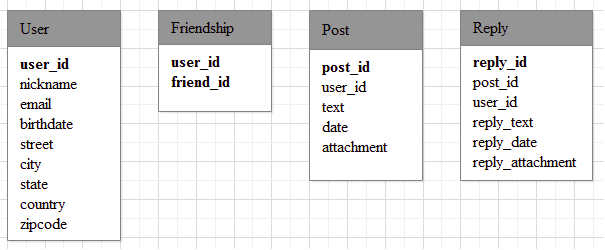

First, the user entity set is converted to a User relation. Because it is a strong relation, it reduces to a schema with the same attributes. The composite attribute adress is flattened out by creating a separate attribute for each of its components (note that adress itself disapears). The attribute user_id constitutes the primary key of the relation (in bold). 

The friendship relationship is turned into a Friendship relation with two attributes: the user id, and each associated friend_id. The two attributes are required to generate a primary key on the table. This way, it is possible to recover the list of all friends (and thus, friend information) associated to each user in the network.

The Post entity set is turned into a Post relation. Being a strong entity, it keeps all its attributes, and post_id remains a primary key. The relationship post_author being one to many, it disapears, only transmitting to the "many" side (Post) the primary key of User (user_id). This is why user_id appears in the Post relation.

Finally, the Reply entity set is turned into a Reply relation. Being a strong entity, it keeps all its attributes, and reply_id remains a primary key. The relationship reply_author being one to many, it disapears, only transmitting to the "many" side (Reply) the primary key of User (user_id). This is why user_id appears in the Reply relation. Also, the one to many relationship "post_reply" between Reply and Post disapears. It only transmits to the "many" side (Reply) the primary key of Post (post_id), which is why posy_id appears in the Reply relation.

This completes the relation schema.

#### Exercise 3.2

Write a view to retrieve the posts to display when a user logs in. Consider that some users may have a lot of friends and you need to limit the number of post to display. How would you select relevant posts to display first? What kind of information would you use/add in the database for this purpose? Explain your answer.

__Note:__ Limiting the number of posts just by count is too simplistic, the user could be missing something interesting to him/her.

My suggestion would be to show to the user all the posts from his/her friends which are of sufficient interest. I would define a post as "sufficiently interesting" whenever the post has generated a sufficient number of replies $n$, the number $n$ in question being defined by the application. For instance, defining $n = 5$, any post from a user's friend with at least 5 replies will be considered as "interesting" and displayed to the user at login. Therefore, the information from the database that I would use would be the number of replies for each post. This defines the following steps to obtain the view of "posts of interests":

1/ Obtain a view of the user's friends (assuming the user id is "user1"):

2/ Obtain a view of all the posts of user's friends; filter to keep only the posts of today (to limit the quantity)

3/ Obtain a view of all the posts of interest among the posts of user's friends

4/ Obtain the final view: eliminate the useless post_id and user_id, and substitute for them the name corresponding the authors of the interesting posts

This eventually produces a view where the user will see all the posts produced this day by his friends whenever they received a number of comments larger than $n$.